First, let's install the alpha version of TensorFlow 2.0.

In [18]:
!pip install tensorflow==2.0.0-alpha0

from tensorflow.python.ops import control_flow_util
control_flow_util.ENABLE_CONTROL_FLOW_V2 = True

And take care of all the other imports that we will need here:

In [19]:
import tensorflow as tf

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split

from os import listdir

### Checking out the data

The training images reside in the `../input/train/train/` directory.

In [ ]:
train_dir = '../input/train/train/'
train_imgs = listdir(train_dir)
nr_train_images = len(train_imgs)
nr_train_images

So we have 17500 training images. Their labels are in the `train.csv` file.

In [ ]:
train_lables_df = pd.read_csv('../input/train.csv', index_col='id')
print('Total entries: ' + str(train_lables_df.size))
print(train_lables_df.head(10))

A first thing to look at is how many positive vs. negative examples we have:

In [ ]:
train_lables_df['has_cactus'].value_counts()

So the dataset does look somewhat imbalanced: 3 times more positive examples than negative. Let's look at a few examples.

In [ ]:
def get_test_image_path(id):
    return train_dir + id

def draw_cactus_image(id, ax):
    path = get_test_image_path(id)
    img = mpimg.imread(path)
    plt.imshow(img)
    ax.set_title('Label: ' + str(train_lables_df.loc[id]['has_cactus']))

fig = plt.figure(figsize=(20,20))
for i in range(12):
    ax = fig.add_subplot(3, 4, i + 1)
    draw_cactus_image(train_imgs[i], ax)

Well, I certainly can't tell much from these pictures. Let's try implementing a simple model to see how it does.

### Loading the data

Since we'll be using TensorFlow, let's construct a `tf.data.Dataset` of the training data: images and labels. First, let's match up the image paths and the labels in a more convenient data structure:

In [ ]:
train_image_paths = [train_dir + ti for ti in train_imgs]
train_image_labels = [train_lables_df.loc[ti]['has_cactus'] for ti in train_imgs]

for i in range(10):
    print(train_image_paths[i], train_image_labels[i])

Now, we need some tensors to flow. To get from the image paths above to actual `tf.Tensor`s we will combine `tf.io.read_file` and `tf.image.decode_image`. This very simple process is illustrated below for the first example:

In [ ]:
def img_to_tensor(img_path):
    img_tensor = tf.cast(tf.image.decode_image(tf.io.read_file(img_path)), tf.float32)
    img_tensor /= 255.0 # normalized to [0,1]
    return img_tensor

img_to_tensor(train_image_paths[0])

So that's how we can easily convert our training examples to tensors of shape (32, 32, 3). Now let's construct our training and validation sets from the images in the train directory.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_image_paths, train_image_labels, test_size=0.2)

def process_image_in_record(path, label):
    return img_to_tensor(path), label

def build_training_dataset(paths, labels, batch_size = 32):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(process_image_in_record)
    ds = ds.shuffle(buffer_size = len(paths))
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

def build_validation_dataset(paths, labels, batch_size = 32):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(process_image_in_record)
    ds = ds.batch(batch_size)
    return ds

train_ds = build_training_dataset(X_train, y_train)
validation_ds = build_validation_dataset(X_valid, y_valid)

Let's see this in action on a small subset of the data:

In [ ]:
mini_train_ds = build_training_dataset(X_train[:5], y_train[:5], batch_size=2)
# Fetch and print the first batch of 2 images
for images, labels in mini_train_ds.take(1):
    print(images)
    print(labels)

### Building a simple model with the tf.keras Sequential API

Just to get the ball rolling, let's create a simple feed-forward network with a somewhat arbitrary choice of hyperparameters: after flattening the input, I will add two hidden layers with `ReLu` activations having 256 and 64 units, respectively and a layer with a single unit and `Sigmoid` activation for the output, since we're in a classic binary classification setup.

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, epochs=20, steps_per_epoch=400, validation_data=validation_ds)

Ok, looks like this simple model is learning *something* and we reach about 90% accuracy on the validation set. Let's plot the losses and accuracies over time to see a bit more clearly how our network learnt.

In [ ]:
def plot_accuracies_and_losses(history):
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    
    plt.title('Cross-entropy loss')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()

plot_accuracies_and_losses(history)

First and foremost, this is an important sanity check: we can see that our model is gradually learning and getting better on both the training and validation sets. This gives us some confidence that there should be no glaring mishaps in the way we set up the data pipeline or the model.

And second, while the graphs look a little noisy, the curves seem to be improving over time for both the training and validation sets, so there are no signs of overfitting. It therefore seems worth exploring a more complex model in the hopes of getting a better score.

### Using convolutions

Convolutional Neural Networks are the go-to type of neural network architectures for tackling tasks on image data, so let's try applying such a model to our problem.

In [ ]:
cnn_model = tf.keras.Sequential()

cnn_model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)))
cnn_model.add(tf.keras.layers.MaxPooling2D((2,2)))
cnn_model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D((2,2)))
cnn_model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))

cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(64, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
cnn_model.summary()

In [ ]:
history = cnn_model.fit(train_ds, epochs=20, steps_per_epoch=400, validation_data=validation_ds)

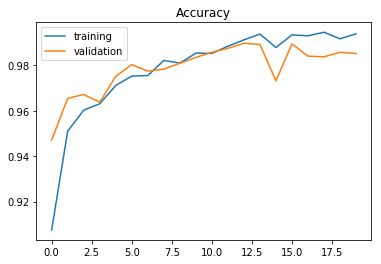

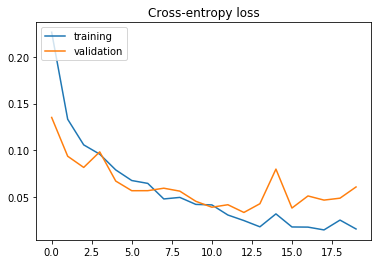

In [20]:
plot_accuracies_and_losses(history)

That's what you want to see!

We clearly could have stopped training quite a bit earlier, but again we don't seem to be overfitting. So there's potential room for improvement here by choosing a more complex model.

But most importantly, the convolutional network gave us a big boost: going from 90% to a solid 98-99% accuracy on the validation set. With literally 0 effort put into tuning the model. Will do for now. Time to make a submission.

### Visualizing what the CNN learns

While the few pictures we looked at in the beginning didn't seem very clear, the `cnn_model` is certainly able to figure out where those cacti are. The nice thing about CNNs is that we can actually visualize what is being learnt. Let's do that next.

In [21]:
# Following the example in https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras
layer_outputs = [layer.output for layer in cnn_model.layers]
activation_model = tf.keras.Model(inputs=cnn_model.input, outputs=layer_outputs)

def print_example_and_activations(example, col_size, row_size, act_index): 
    example_array = img_to_tensor(example).numpy()
    plt.imshow(example_array)
    activations = activation_model.predict(example_array.reshape(1,32,32,3)) # batch of 1 - just the example array
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray') # image for the first (and only) element in the batch at activation_index
            activation_index += 1

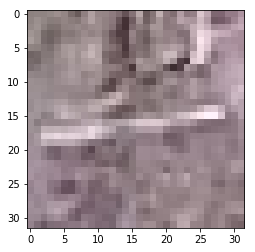

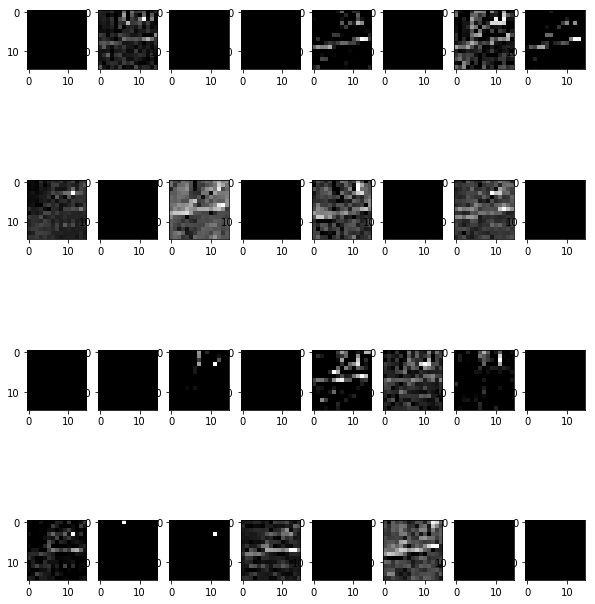

In [22]:
# Visualizing layer 1
print_example_and_activations(X_train[0], 8, 4, 1)

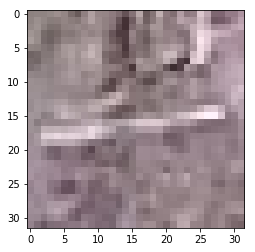

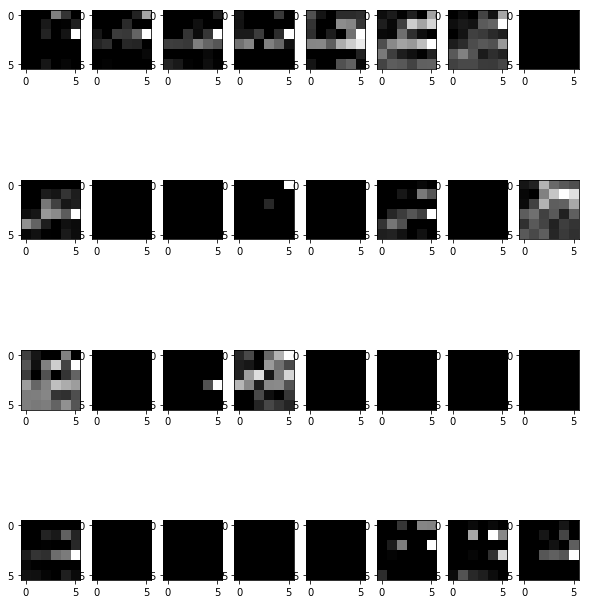

In [23]:
# Visualizing layer 3
print_example_and_activations(X_train[0], 8, 4, 3)

### Making a submission

In [24]:
test_dir = '../input/test/test/'
test_imgs = listdir(test_dir)
print(len(test_imgs))
test_imgs[:5]

4000


['9cdda32671cb192f096b20c91b46a150.jpg',
 'da498fc860c8b76ca925c4218c5f0373.jpg',
 '433052030eeb117e4bd8f6ce033c9da4.jpg',
 '4c76899a6e4b4a6cfdd2f28707fa8114.jpg',
 '9efa3e92c1475b3ce4b7e2e598fa2785.jpg']

In [25]:
def path_to_numpy_array(path):
    tensor = img_to_tensor(path)
    array = tensor.numpy()
    return array

test_image_paths = [test_dir + ti for ti in test_imgs]
test_instances = np.asarray([path_to_numpy_array(tip) for tip in test_image_paths])

test_instances[:2]

array([[[[0.38431373, 0.33333334, 0.36862746],
         [0.39607844, 0.34509805, 0.38039216],
         [0.40392157, 0.3529412 , 0.3882353 ],
         ...,
         [0.32941177, 0.29803923, 0.2901961 ],
         [0.33333334, 0.3019608 , 0.29411766],
         [0.3019608 , 0.27058825, 0.2627451 ]],

        [[0.4       , 0.34901962, 0.38431373],
         [0.40784314, 0.35686275, 0.39215687],
         [0.42352942, 0.37254903, 0.40784314],
         ...,
         [0.34509805, 0.3137255 , 0.30588236],
         [0.32156864, 0.2901961 , 0.28235295],
         [0.28627452, 0.25490198, 0.24705882]],

        [[0.3647059 , 0.3137255 , 0.34901962],
         [0.36862746, 0.31764707, 0.3529412 ],
         [0.4       , 0.3372549 , 0.3764706 ],
         ...,
         [0.29803923, 0.2627451 , 0.26666668],
         [0.37254903, 0.34117648, 0.33333334],
         [0.3647059 , 0.33333334, 0.3254902 ]],

        ...,

        [[0.36862746, 0.3372549 , 0.32941177],
         [0.3529412 , 0.32156864, 0.3137255 ]

In [26]:
predictions = cnn_model.predict(test_instances)
print(len(predictions))

4000


In [27]:
submission_data = pd.DataFrame({'id': test_imgs, 'has_cactus': predictions.flatten()})
submission_data.head(20)

,id,has_cactus
0,9cdda32671cb192f096b20c91b46a150.jpg,1.000000
1,da498fc860c8b76ca925c4218c5f0373.jpg,1.000000
2,433052030eeb117e4bd8f6ce033c9da4.jpg,0.999987
3,4c76899a6e4b4a6cfdd2f28707fa8114.jpg,0.029401
4,9efa3e92c1475b3ce4b7e2e598fa2785.jpg,0.999872
5,873191a1575a6292ed92714bfc659b87.jpg,1.000000
6,8f99b87b7a652d68232fbd6379529368.jpg,0.999930
7,316e46903ee485aeecfd229973abcc71.jpg,0.000291
8,fc76ae520f30c6aba6dbfa8e82def89c.jpg,1.000000
9,ee3ddba5f04e0674db0d18a9dd3b8131.jpg,0.001422


In [28]:
submission_data.to_csv('submission.csv', index=False)

In [29]:
!head submission.csv

id,has_cactus
9cdda32671cb192f096b20c91b46a150.jpg,1.0
da498fc860c8b76ca925c4218c5f0373.jpg,1.0
433052030eeb117e4bd8f6ce033c9da4.jpg,0.9999867
4c76899a6e4b4a6cfdd2f28707fa8114.jpg,0.029400826
9efa3e92c1475b3ce4b7e2e598fa2785.jpg,0.999872
873191a1575a6292ed92714bfc659b87.jpg,0.9999995
8f99b87b7a652d68232fbd6379529368.jpg,0.99993014
316e46903ee485aeecfd229973abcc71.jpg,0.00029104948
fc76ae520f30c6aba6dbfa8e82def89c.jpg,1.0
